#### In order to do webscrapping to retrieve images from a google search, you need to install certain packages. 

In [1]:
!pip install selenium
!pip install Pillow
!pip install webdriver-manager
# install the below if you have mac
# !brew install chromedriver

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio
import matplotlib.ticker as mtick
import urllib
import selenium
import time
import io
import requests
from PIL import Image
import hashlib

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

In [3]:
wd = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 95.0.4638
Get LATEST chromedriver version for 95.0.4638 google-chrome
Driver [/Users/maximegevers/.wdm/drivers/chromedriver/mac64/95.0.4638.69/chromedriver] found in cache
<ipython-input-3-eb99f935bb87>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  wd = webdriver.Chrome(ChromeDriverManager().install())


the DRIVER_PATH is the same for everyone. In other words, the path isn't specific to my laptop. This is the case, becasue we use 'ChromeDriverManager' with the webdriver. 

In [4]:
DRIVER_PATH = '/usr/local/bin/chromedriver'

#### Investigate the images itself

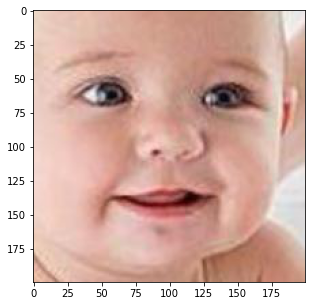

In [5]:
%matplotlib inline
pic = imageio.imread('/Users/maximegevers/AI_Concordia/AI_project/EDA/data/without/1_0_0_20161219193326339.jpg.chip.jpg')
plt.figure(figsize = (5,5))
plt.imshow(pic);

In [6]:
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Image Higth {}'.format(pic.shape[0])) 
print('Image Width {}'.format(pic.shape[1])) 
print('Dimension of Image {}'.format(pic.ndim))

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (200, 200, 3)
Image Higth 200
Image Width 200
Dimension of Image 3


In [7]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = 'https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img'

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [8]:
def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

notice that we set number_images=100, this could have been any other number. 

In [9]:
def search_and_download(search_term:str,driver_path:str,target_path='./images',number_images=100):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)

In [10]:
search_and_download(search_term='person with kn95 face mask', driver_path=DRIVER_PATH)

<ipython-input-9-1fe8918b0e55>:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  with webdriver.Chrome(executable_path=driver_path) as wd:
<ipython-input-7-0cf2265784ed>:19: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")


Found: 100 search results. Extracting links from 0:100


<ipython-input-7-0cf2265784ed>:33: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  actual_images = wd.find_elements_by_css_selector('img.n3VNCb')


Found: 100 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTAEvjOdi1tCYW2hZVkpTGHZoMWmJe2RbhgMg&usqp=CAU - as ./images/person_with_kn95_face_mask/8646b3ef02.jpg
SUCCESS - saved https://thumbnails.texastribune.org/fFI4uGr2vWetl_pNeoFkIfLZp5Q=/1200x630/filters:quality(95):watermark(cdn.texastribune.org/media/watermarks/2020.png,-0,30,0)/static.texastribune.org/media/files/8428e6e5261a9d26ec9a46e79f6ef3ce/N95%20face%20masks%20REUTERS%20TT.jpg - as ./images/person_with_kn95_face_mask/249482a385.jpg
SUCCESS - saved https://static.onecms.io/wp-content/uploads/sites/20/2021/10/07/amazon-pack-face-mask-reusable-tout.jpg - as ./images/person_with_kn95_face_mask/964435a956.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcStHxZv41T5FhEx8UZTHJxyQhU4s-V8PKFu8w&usqp=CAU - as ./images/person_with_kn95_face_mask/7d71edb599.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTuHRBHi3AL-JI_ODH926xdv_3QoN2a9MZpKQ&usqp

SUCCESS - saved https://i.insider.com/5e56a422fee23d7bbc714a79?width=1100&format=jpeg&auto=webp - as ./images/person_with_kn95_face_mask/9f8ed82cde.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSS6rGJOitl968spYSoSShS6bga6ulW6TnWcA&usqp=CAU - as ./images/person_with_kn95_face_mask/d6feed25a9.jpg
SUCCESS - saved https://static.onecms.io/wp-content/uploads/sites/20/2021/01/22/kn95-face-mask-tout.jpg - as ./images/person_with_kn95_face_mask/c0267c5b73.jpg
SUCCESS - saved https://www.ge.com/news/sites/default/files/Reports/2020-03/Mask-Shield-with-nub.jpg - as ./images/person_with_kn95_face_mask/d0b878a406.jpg
SUCCESS - saved https://media.wired.co.uk/photos/606d9e4a346a830acc53c501/4:3/w_2672,h_2004,c_limit/wired-best-n95-1.jpg - as ./images/person_with_kn95_face_mask/24ad72f42c.jpg
SUCCESS - saved https://images.thdstatic.com/productImages/b4db32f1-1bcc-42d6-8762-094758f15968/svn/white-face-masks-kn9510pack-64_600.jpg - as ./images/person_with_kn95_face_mask/c3

SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRHAVIcF879bz9qs0RDsm78bHR5gdpV3E4M0A&usqp=CAU - as ./images/person_with_kn95_face_mask/33b1800a9c.jpg
SUCCESS - saved https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F34%2F2020%2F09%2F14%2Fwoman-wearing-n95-mask-getty-0920-2000.jpg&q=85 - as ./images/person_with_kn95_face_mask/407270428d.jpg
SUCCESS - saved https://media-cldnry.s-nbcnews.com/image/upload/newscms/2021_09/3453102/kn95-msk-800x-6039814c7fdaa.png - as ./images/person_with_kn95_face_mask/5b4ed5731d.jpg
SUCCESS - saved https://www.gannett-cdn.com/presto/2020/08/13/USAT/a75419d5-b13b-493e-bf95-dec175b85352-mask_art_8.png - as ./images/person_with_kn95_face_mask/4fdf4f7d91.jpg
SUCCESS - saved https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/n95-mask-social-1612279582.jpg?crop=1.00xw:1.00xh;0,0&resize=1200:* - as ./images/person_with_kn95_face_mask/2fc4a4cd6d.jpg
ERROR - Could not sav